# CNN

In [35]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten,Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Dense # fully-connected net
from keras import backend as K

# simple cnn model on cifar10 small images dataset

class Cnn:
  @staticmethod
  def build(width, height, depth, classes):
    # parameter: classes means the total number of classes we want to recognize
    #initialize the model
    model = Sequential()
    inputShape = (height, width, depth)

    # if we are using "channel first", update the input shape
    # in some situation like TH, use channel first
    if K.image_data_format() == "channel_first":
      inputShape = (depth, height, width)

    # first set of CONV => RELU => POOL layers => Dropout
    # conv layer will learn 32 convolution filters, each of which are 3*3
    model.add(Conv2D(32, (3, 3),padding = "same",input_shape = inputShape))
    model.add(Activation("relu"))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # second set of CONV => RELU => POOL layers => Dropout
    model.add(Conv2D(64, (3, 3),padding = "same"))
    model.add(Activation("relu"))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # flattening out the volume into a set of fully-connected layer
    # first and only set of FC => RELU laters
    model.add(Flatten())
    # fully-connected layer has 512 units
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    # softmax classifier (output layer)
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    #return the constructed network architecture
    return model

In [ ]:
model = Cnn.build(width=32, height=32, depth=3, classes=8)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [37]:
import numpy as np

def get_vectors():
    vectors = {}
    #f=open("glove.6B.50d.txt")
    f=open("glove.6B.300d.txt")
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse','ship', 'truck']
    for i in f:
        word = i.split()[0]
        if word in classes:
          vectors[word] = i.split()[1:]
    return vectors

In [38]:
# Real-time ploting
import matplotlib.pyplot as plt
import keras
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        

# Training stage

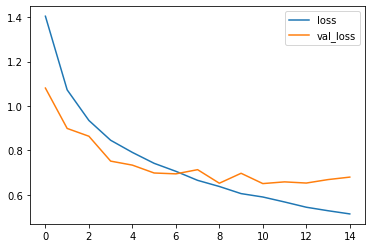

1250/1250 [==============================] - 179s 143ms/step - loss: 0.5136 - accuracy: 0.8152 - val_loss: 0.6794 - val_accuracy: 0.7738
Saved trained model at /content/saved_models/keras_zsl_cifar10_trained_model.h5 


In [39]:
""" 
we will do 4 things in this file
1. Load image dataset from disk, get word vector
2. Pre-process the images if needed
3. Instantiate out convolutional neural network
4. Train out image classifier getting top N classification probability of image
5. Combine probability and word vector getting class of image
"""

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
import tensorflow as tf
#from cnn import Cnn
#import word_vector
import numpy as np
import cv2
import os
from keras.models import load_model

# initialize the number of epochs to train for, initial learning rate and batch size
batch_size = 32
num_classes = 8
epochs = 50
optimizer = "Adam"
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_zsl_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# remove ship and truck class to get train data
removed_indices = np.where(y_train!=8)[0]
x_new_train = x_train[removed_indices]
y_new_train = y_train[removed_indices]
removed_indices = np.where(y_new_train!=9)[0]
x_new_train = x_new_train[removed_indices]
y_new_train = y_new_train[removed_indices]

# remove ship and truck class to get validation data
removed_indices = np.where(y_test!=8)[0]
x_new_validation = x_test[removed_indices]
y_new_validation = y_test[removed_indices]
removed_indices = np.where(y_new_validation!=9)[0]
x_new_validation = x_new_validation[removed_indices]
y_new_validation = y_new_validation[removed_indices]

# Convert class vectors to binary class matrices, like one-hot-encoding
y_new_train = keras.utils.to_categorical(y_new_train,num_classes)
y_new_validation = keras.utils.to_categorical(y_new_validation,num_classes)

x_new_train = x_new_train.astype('float32')
x_new_validation = x_new_validation.astype('float32')
x_new_train /= 255
x_new_validation /= 255

plot_losses = PlotLosses()

model = Cnn.build(width=32, height=32, depth=3, classes=8)

if optimizer == "rms":
  # initiate RMSprop optimizer
  opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
else:
  # initiate Adam optimizer
  opt = keras.optimizers.Adam(lr=0.001)

#  categorical_crossentropy

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_new_train, y_new_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_new_validation, y_new_validation),
              callbacks=[plot_losses, callback],
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_new_train, y_new_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_new_validation, y_new_validation),
                        workers=4)
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
def cosine_similarity(v1, v2):
    """
    Performs cosine similarity measure between two given vectors - v1 and v2, s.t. cosine_similarity = (v1.v2)/(||v1||.||v2||)

    Arguments:
    v1 -- a real-number vector
    v2 -- a real-number vector

    Returns:
    cos -- the value of similarity between v1 and v2
    """
    cos = (np.dot(v1,v2))/(np.linalg.norm(v1)*np.linalg.norm(v2))

    return cos

# Test stage

In [40]:
from keras.models import load_model

print("[INFO] loading network...")
model = load_model('saved_models/keras_zsl_cifar10_trained_model.h5')

indices = np.where(y_test >= 8)[0]
y_new_test = y_test[indices]
x_new_test = x_test[indices]

# combine probability got from cnn and word vector
cnn_prob = model.predict(x_new_test)

# get word vectors of seen classes
embeddings = get_vectors()
weights = []
for i in class_labels[:-2]:
  weights.append(embeddings[i])
weights = np.array(weights,dtype=np.float32)

# Predicted word embedding by convex combination
cnn_embedding = np.dot(cnn_prob,weights)

# Get all target_embeddings
target_embeddings = []
for i in class_labels:
	target_embeddings.append(embeddings[i])
target_embeddings = np.array(target_embeddings, dtype=np.float32)

# Use KNN to find the nearest class
from scipy.spatial import distance
from sklearn.metrics import accuracy_score

n_samples = cnn_embedding.shape[0]

# Calculate distance between the estimated representation and the projected prototypes
dist = distance.cdist(cnn_embedding, target_embeddings, metric='cosine')
# Get the index of min distances
idx_min = np.argmin(dist, axis=1)
# Get the labels of predictions
preds = y_new_test[[i for i in idx_min]]

# Calculate Top-1 accuracy
diff = y_new_test - preds
n_incorrect = len(np.nonzero(diff)[0])
mean_accuracy = (n_samples - n_incorrect) / n_samples
    
print("Accuracy: %.2f%%" % (mean_accuracy*100))
#for i,j in zip(y_new_test, preds):
#    print (i,j)

[INFO] loading network...
Accuracy: 50.40%
